# Adversarial example using pytorch

In this example, we redo the [adversarial example](https://gurobi-optimization-ml2gurobi.readthedocs-hosted.com/en/latest/examples/adversarial_mnist.html) of the documentation but use pytorch for training the neural network.

We don't detail the optimization model here. Please refer to the example in the documentation.

This example requires the additional packages:
 - [torch](https://pytorch.org/)
 - [torchvision](https://pytorch.org/)
 - [matplotlib](https://matplotlib.org/)
 - [skorch](https://skorch.readthedocs.io/en/stable/)

 The latter package is a wrapper for giving to pytorch a Scikit-Learn like interface.

## Import the necessary packages and load data

We import all the package we need for this example.
We fetch the MINST data set using sklearn's functionalities.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

import torch
import torchvision
from skorch import NeuralNetClassifier

import gurobipy as gp

from gurobi_ml import add_predictor_constr

In [32]:
# Get MNIST digit recognition data set
mnist_train = torchvision.datasets.MNIST(root="../Datset/MNIST", train=True, download=True)

mnist_test = torchvision.datasets.MNIST(root="./Datset/MNIST", train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 32134499.03it/s]


Extracting ./Datset/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./Datset/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 1803392.74it/s]


Extracting ./Datset/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./Datset/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 10800713.70it/s]


Extracting ./Datset/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./Datset/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8366503.63it/s]

Extracting ./Datset/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./Datset/MNIST/MNIST/raw



Flatten and scale the data

In [49]:
x_train = torch.flatten(mnist_train.data.type(torch.FloatTensor), start_dim=1)
y_train = mnist_train.targets
x_test = torch.flatten(mnist_test.data.type(torch.FloatTensor), start_dim=1)
y_test = mnist_test.targets

x_train /= 255.0  # scaling
x_test /= 255.0  # scaling

## Construct and train the neural network

We construct a sequential neural network with 2 hidden layers of 50 neurons.
To train it, we use `skorch` that provides an interface similar to `scikit-learn`.

In [40]:
nn_model = torch.nn.Sequential(
    torch.nn.Linear(28 * 28, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 50),
    torch.nn.ReLU(),
    torch.nn.Linear(50, 10),
    torch.nn.Softmax(1),
)

In [68]:
clf = NeuralNetClassifier(
    nn_model,
    max_epochs=5,
    lr=0.1,
    iterator_train__shuffle=True,
)

clf.criterion

torch.nn.modules.loss.NLLLoss

In [69]:

clf.fit(X=x_train, y=y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.0185       0.9587        0.2128  0.9665
      2        0.0178       0.9606        0.2076  0.9479
      3        0.0180       0.9603        0.2107  0.9188
      4        0.0174       0.9605        0.2126  0.9828
      5        0.0173       0.9593        0.2132  0.9898


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=Sequential(
    (0): Linear(in_features=784, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=50, bias=True)
    (3): ReLU()
    (4): Linear(in_features=50, out_features=10, bias=True)
    (5): Softmax(dim=1)
  ),
)

In [70]:
clf.criterion

torch.nn.modules.loss.NLLLoss

In [67]:
clf.optimizer_

SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    lr: 0.1
    maximize: False
    momentum: 0
    nesterov: False
    weight_decay: 0
)

In [54]:
print(f"Training score: {clf.score(x_train, y_train):.4}")
print(f"Validation set score: {clf.score(x_test, y_test):.4}")

Training score: 0.9796
Validation set score: 0.9626


In [21]:
nn_regression = torch.nn.Sequential(*nn_model[:-1])
nn_regression

Sequential(
  (0): Linear(in_features=784, out_features=50, bias=True)
  (1): ReLU()
  (2): Linear(in_features=50, out_features=50, bias=True)
  (3): ReLU()
  (4): Linear(in_features=50, out_features=10, bias=True)
)

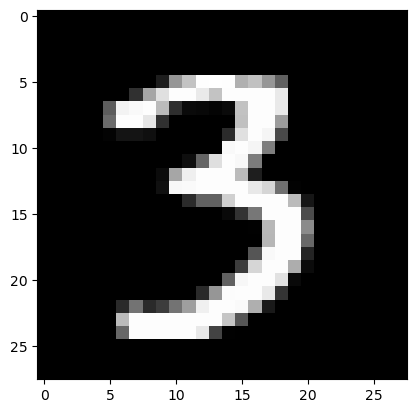

In [9]:
imageno = 10000
image = mnist_train.data[imageno, :]
plt.imshow(image, cmap="gray")

In [17]:
ex_prob = nn_regression.forward(x_train[imageno, :])
sorted_labels = torch.argsort(ex_prob)
right_label = sorted_labels[-1]
wrong_label = sorted_labels[-2]

In [22]:
image.shape

(784,)

In [23]:
ex_prob.detach().numpy().shape

(10,)

In [18]:
image = x_train[imageno, :].numpy()  # We need numpy converted image

m = gp.Model()
delta = 5

x = m.addMVar(image.shape, lb=0.0, ub=1.0, name="x")
y = m.addMVar(ex_prob.detach().numpy().shape, lb=-gp.GRB.INFINITY, name="y")

abs_diff = m.addMVar(image.shape, lb=0, ub=1, name="abs_diff")

m.setObjective(y[wrong_label] - y[right_label], gp.GRB.MAXIMIZE)

# Bound on the distance to example in norm-1
m.addConstr(abs_diff >= x - image)
m.addConstr(abs_diff >= -x + image)
m.addConstr(abs_diff.sum() <= delta)

pred_constr = add_predictor_constr(m, nn_regression, x, y)

pred_constr.print_stats()

Model for sequential:
200 variables
110 constraints
100 general constraints
Input has shape (1, 784)
Output has shape (1, 10)

--------------------------------------------------------------------------------
Layer           Output Shape    Variables              Constraints              
                                                Linear    Quadratic      General
linear_0             (1, 50)           50           50            0            0

relu_1               (1, 50)           50            0            0           50

linear_2             (1, 50)           50           50            0            0

relu_3               (1, 50)           50            0            0           50

linear_4             (1, 10)            0           10            0            0

--------------------------------------------------------------------------------


In [19]:
m.Params.BestBdStop = 0.0
m.Params.BestObjStop = 0.0
m.optimize()

Set parameter BestBdStop to value 0
Set parameter BestObjStop to value 0
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD EPYC 7402 24-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 48 physical cores, 96 logical processors, using up to 32 threads

Optimize a model with 1679 rows, 1778 columns and 46230 nonzeros
Model fingerprint: 0xd037b8f4
Model has 100 general constraints
Variable types: 1778 continuous, 0 integer (0 binary)
Coefficient statistics:
  Matrix range     [2e-06, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-03, 5e+00]
Presolve removed 1110 rows and 589 columns
Presolve time: 0.20s
Presolved: 569 rows, 1189 columns, 43591 nonzeros
Variable types: 1118 continuous, 71 integer (71 binary)

Root relaxation: objective 6.820081e+02, 477 iterations, 0.01 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

In [13]:
if m.ObjVal > 0.0:
    plt.imshow(x.X.reshape((28, 28)), cmap="gray")
    x_input = torch.tensor(x.X.reshape(1, -1), dtype=torch.float32)
    label = torch.argmax(nn_model.forward(x_input))
    print(f"Solution is classified as {label}")
else:
    print("No counter example exists in neighborhood.")

No counter example exists in neighborhood.


copyright © 2022 Gurobi Optimization, LLC